# Classification. Linear models and KNN

In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt, exp

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
# import warnings

# #suppress warnings
# warnings.filterwarnings('ignore')

class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.X_ext = None
        self.loss_hist = []
        self.delta_hist = []
        self.w_norm_hist = []
         
    def get_sigmoid(self, X, weights):
        def sigm(z):
            return 1 / (1 + exp(-z))
        lin = X@weights
        return np.fromiter(map(sigm, lin), dtype='float')
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""

        self.w_norm_hist.append((np.linalg.norm(weights)**2).mean())
        return (1/x.shape[0])*\
                np.log(1+np.exp(-(weights@x.T)*y)).sum()+\
                ((1/(2*self.C))*(np.linalg.norm(weights)**2))

     
    def fit(self, X, y):
        from mpmath import mp
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        self.X_ext = X_ext
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization

        for i in range(self.max_iter): 
            delta = np.zeros((65,))
            for j in range(X_ext.shape[0]): 
                sample = y[j]*X_ext[j]*(1-(1/(1+np.exp(-(X_ext[j]@self.weights_)*y[j]))))
                delta = np.vstack([delta, sample])
            delta = (1/X_ext.shape[0])*delta.sum(axis=0) - (self.weights_/self.C)
            delta = - delta 
            self.weights_ -= self.eta * delta
            self.loss_hist.append(self.get_loss(X_ext, self.weights_, y))
            delta_norm = np.linalg.norm(self.eta*delta)
            self.delta_hist.append(delta_norm)
            if np.linalg.norm(delta_norm) < self.tol:
                break
        
        
                
    
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        y_hat = self.predict_proba(X)
        return [1 if e>0.5 else -1 for e in y_hat]

In [5]:
from sklearn import datasets
from sklearn import metrics

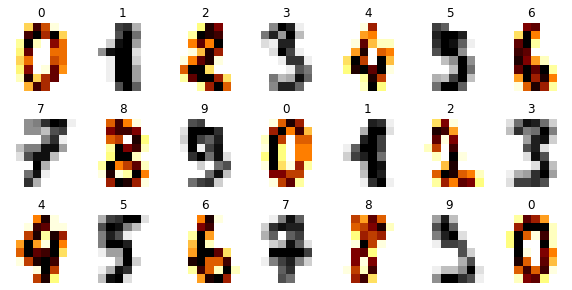

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
lr_clf.weights_

array([ 3.13152401e-06,  0.00000000e+00,  4.17536534e-05,  5.47668754e-04,
        2.21294363e-04,  4.87473904e-04,  1.35768963e-03,  5.97773138e-04,
        5.63674322e-05, -6.95894224e-07,  1.69102296e-04,  2.51913709e-04,
       -4.37021573e-04,  3.61864997e-04,  1.00487126e-03,  4.22755741e-04,
        2.57480863e-05,  3.47947112e-07, -1.14822547e-05, -7.24425887e-04,
       -2.62004175e-04,  8.75434934e-04,  4.15448852e-04, -8.42032011e-05,
       -5.21920668e-06,  0.00000000e+00, -2.21642310e-04, -5.71329158e-04,
        9.85734168e-04,  1.35073069e-03,  5.02087683e-04, -1.70494085e-04,
       -1.04384134e-06,  0.00000000e+00, -6.78148921e-04, -1.05149617e-03,
       -4.45372303e-05,  3.71607516e-04,  4.21016006e-04, -8.17675713e-05,
        0.00000000e+00, -5.21920668e-06, -5.34098817e-04, -2.03931802e-03,
       -8.43075852e-04,  1.04036186e-04, -1.23869172e-04, -1.78844816e-04,
       -1.32219903e-05, -4.52331246e-06, -9.42936674e-05, -1.11273486e-03,
       -5.09046625e-04, -

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression()

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


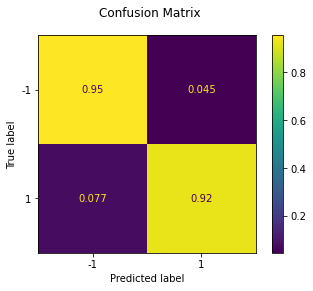

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

**Построим график изменения показателя loss**

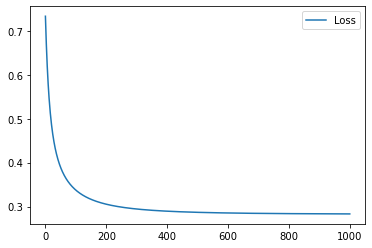

In [18]:
pd.DataFrame(model.loss_hist, columns=['Loss']).plot();

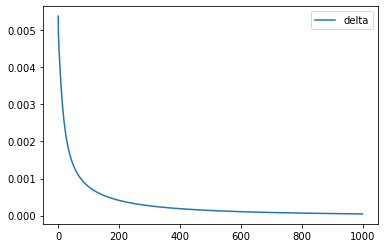

In [19]:
pd.DataFrame(model.delta_hist, columns=['delta']).plot();


<AxesSubplot:>

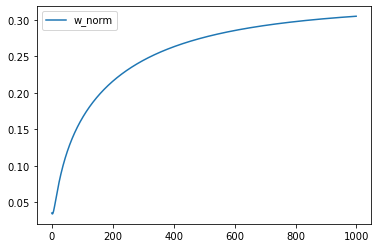

In [20]:
pd.DataFrame(np.array(model.w_norm_hist)**0.5, columns=['w_norm']).plot()

**Значение фунции потерь плавно снижается приближаясь к нулю**

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [21]:
def fit_evaluate_2(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    plt.figure();
    f = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true');
    f.figure_.suptitle("Confusion Matrix");
    plt.show();
    plt.figure();
    pd.DataFrame(clf.loss_hist, columns=['Loss']).plot();
    plt.title("Loss Function");
    plt.show();
    print("Точность классификации на тренировочных данных:", metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train))
    print("Точность классификации на тестовых данныx:", metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

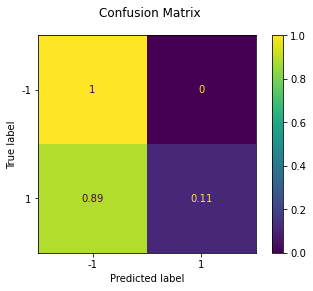

<Figure size 432x288 with 0 Axes>

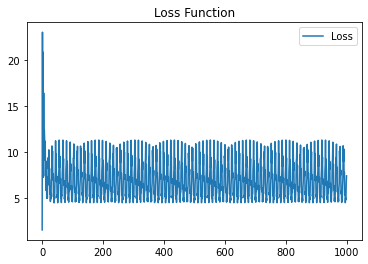

Точность классификации на тренировочных данных: 0.5671537926235213
Точность классификации на тестовых данныx: 0.55


In [22]:
model2 = CustomLogisticRegression(eta = 0.05)
train_acc, test_acc = fit_evaluate_2(model2, X_train, y_train, X_test, y_test);
pass

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

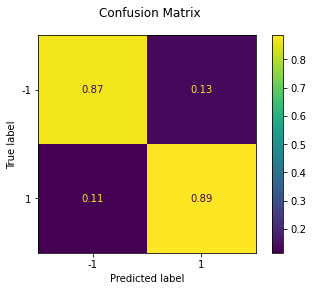

<Figure size 432x288 with 0 Axes>

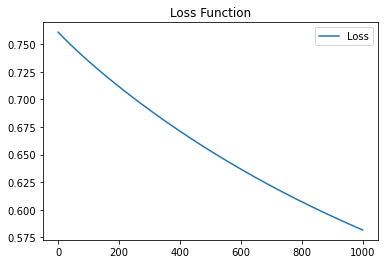

Точность классификации на тренировочных данных: 0.848990953375087
Точность классификации на тестовых данныx: 0.8777777777777778


In [23]:
model3 = CustomLogisticRegression(eta = 0.00001)
train_acc, test_acc = fit_evaluate_2(model3, X_train, y_train, X_test, y_test)

**При слишком высоком значении eta модели не удается приблизится к оптипальным значениям. Высокое значение eta приводит к высоким поправкам к весам, происходит проскакивание оптимума. При слишком малом значении eta веса оптимизируются слишком плавно и долго движутся к оптимальным значениям.**

**(0.5 points)** Try different regularization parameter values and compare the model quality.

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

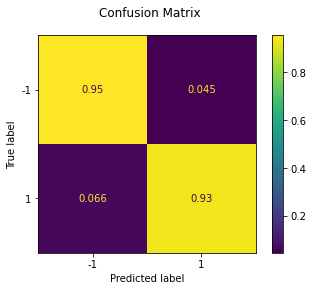

<Figure size 432x288 with 0 Axes>

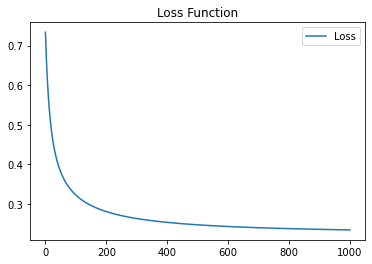

Точность классификации на тренировочных данных: 0.9151009046624913
Точность классификации на тестовых данныx: 0.9444444444444444


In [24]:
model4 = CustomLogisticRegression(C=4.0)
train_acc, test_acc = fit_evaluate_2(model4, X_train, y_train, X_test, y_test)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

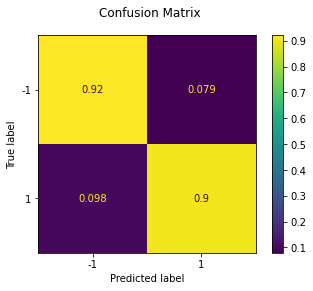

<Figure size 432x288 with 0 Axes>

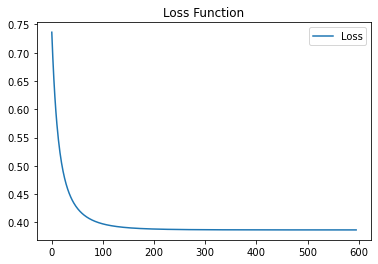

Точность классификации на тренировочных данных: 0.8963117606123869
Точность классификации на тестовых данныx: 0.9111111111111111


In [25]:
model5 = CustomLogisticRegression(C=0.2)
train_acc, test_acc = fit_evaluate_2(model5, X_train, y_train, X_test, y_test)

In [26]:
print("Значение функции потерь при С=4.0:",model4.loss_hist[-1])
print("Значение функции потерь при С=0.2:",model5.loss_hist[-1])

Значение функции потерь при С=4.0: 0.23477683164207275
Значение функции потерь при С=0.2: 0.3867237285785986


**Меньше значение "C" означает большую регуляризацию. В нашем случае большая регуляризация ухудшила точность классификации, по той причине что наши данные представляют собой значения пикселей картинки, где каждый элемент может нести значимую информацию. Возможно для картинок с большим процентом пустых пикселей увеличение значения регуляризации могло бы улучшить результат**

**(0.5 points)** Compare zero initialization and random initialization. 

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

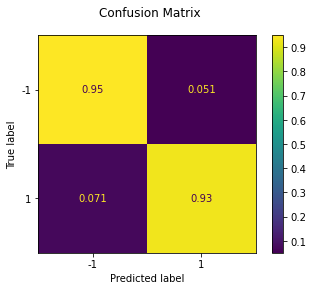

<Figure size 432x288 with 0 Axes>

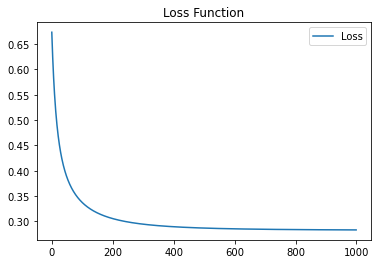

Точность классификации на тренировочных данных: 0.9116214335421016
Точность классификации на тестовых данныx: 0.9388888888888889


In [27]:
model6 = CustomLogisticRegression(zero_init=True)
train_acc, test_acc = fit_evaluate_2(model6, X_train, y_train, X_test, y_test)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

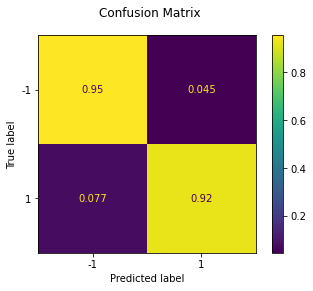

<Figure size 432x288 with 0 Axes>

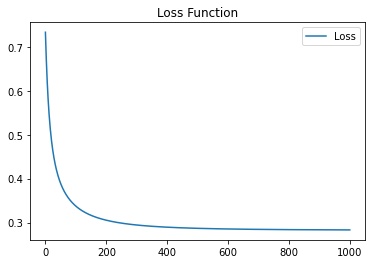

Точность классификации на тренировочных данных: 0.9109255393180237
Точность классификации на тестовых данныx: 0.9388888888888889


In [28]:
model7 = CustomLogisticRegression(zero_init=False)
train_acc, test_acc = fit_evaluate_2(model7, X_train, y_train, X_test, y_test)

In [29]:
print("Значение функции потерь при С=4.0:",model6.loss_hist[-1])
print("Значение функции потерь при С=0.2:",model7.loss_hist[-1])

Значение функции потерь при С=4.0: 0.283047221137981
Значение функции потерь при С=0.2: 0.2830882041160162


**Значения точности инициализации с нулевым весом в нашем случае не отличаются значимо от значений при инициализации со случайными весами. Инициализация с нулевым весом дала чуть лучший результат на тренировочных данных. Можно предположит что среднее значение оптимальных весов близко к нулю, по этому не видно разницы со случайной инициализацией. Для другого набора данных разница может проявиться сильнее.**

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [30]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        self.classes_ = None
        
    
    def get_pairwise_distances(self, X, Y):
        
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return np.array([[sqrt(sum((i-j)**2)) for j in Y] for i in X])
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        df = pd.DataFrame()
        df["classes"] = y
        df["weights"] = weights
        dfg = df.groupby(["classes"]).sum()
        return np.array([dfg[dfg.index == c]["weights"].item() if c in dfg.index else 0 for c in self.classes_])
        
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1/(P + self.eps)
            num_samples = X.shape[0]
            result = []
            for i in range(num_samples):
                df = pd.DataFrame()
                df["P"] = P[i]
                df["weights"] = weights_of_points[i]
                df["classes"] = self.y
                df = df.sort_values("P")
                df_limit = df.iloc[0:self.n_neighbors]
                y = df_limit["classes"].to_numpy()
                weights = df_limit["weights"].to_numpy() 
                class_weights = self.get_class_weights(y, weights)
                sum_weights = class_weights.sum()
                class_weights = class_weights / sum_weights
                result.append(class_weights)
            return np.array(result)
             
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        proba = self.predict_proba(X)
        results = []
        for i in range(X.shape[0]):
            df = pd.DataFrame()
            df["classes"] = self.classes_
            df["P"] = proba[i]
            results.append(df[df["P"] == df["P"].max()]["classes"].iloc[0])
        return np.array(results)
            

In [31]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [32]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [33]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

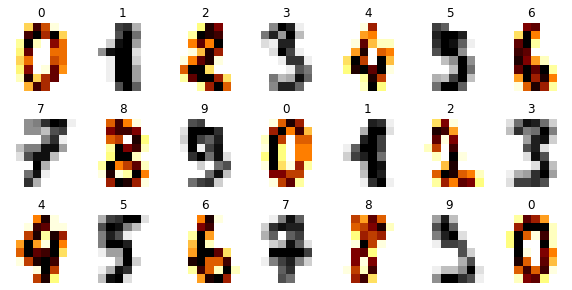

In [34]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [35]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [36]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


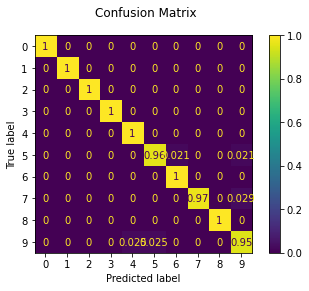

In [37]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [38]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

**Из матрицы ошибок видно, что модель путает сходные по написанию цифры между собой. Так предсказанная 9 оказывается на самом деле 5 и 7. Что не удивительно, в представленном образце 5 трудно отличить от 9. Истинную 9 модель классифицировала как 4 и 5. В целом показатели предсказания очень хорошие, а для цифр от 0 до 3 даже идеальные.**

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [59]:
def fit_evaluate_knn(X_train, y_train, X_test, y_test, k_range, weights='distance'):
    acc_train = []
    acc_test = []
    for knn in range(1, k_range):
        clf = CustomKNeighborsClassifier(n_neighbors=knn, weights=weights)
        clf.fit(X_train, y_train)
        acc_train.append(metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train))
        acc_test.append(metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
    return acc_train, acc_test

In [40]:
acc_train, acc_test = fit_evaluate_knn(X_train, y_train, X_test, y_test, 100)

**Построим график отображающий изменения точности модели с ростом числа ближайших соседей**

   train      test
5    1.0  0.988889
6    1.0  0.988889


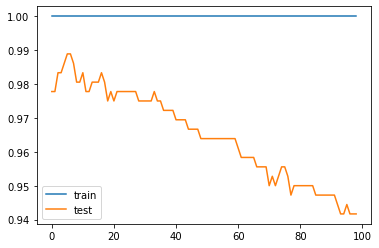

In [57]:
acc_df = pd.DataFrame()
acc_df["train"] = acc_train
acc_df["test"] = acc_test
acc_df.plot()
print(acc_df[acc_df["test"] == acc_df["test"].max()])

**Сравнение показывает, что с ростом числа ближайших соседей падает точность предсказания. Оптимальным числом соседей для данного набора данных будет 5-6, чтоб соответсвует максимальной точности на графике**

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

**Соберем данные оценки точности для модели с равномерным распределением весов, до параметра ближайших соседей равного 25**

In [60]:
acc_train_uni, acc_test_uni = fit_evaluate_knn(X_train, y_train, X_test, y_test, 25, weights="uniform")


**Построим совместный график для равномерного и пропорционального распределения весов**

<AxesSubplot:>

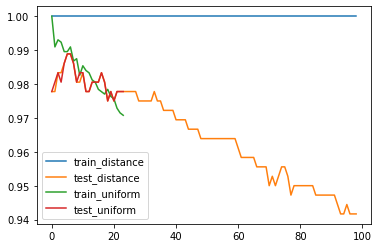

In [72]:
acc_uni = pd.DataFrame()
acc_uni["train_uniform"] = acc_train_uni
acc_uni["test_uniform"] = acc_test_uni
acc_df = acc_df.rename(columns={"train": "train_distance", "test": "test_distance"})
acc_df_con = pd.concat([acc_df, acc_uni], axis = 1)
acc_df_con.plot()

**Интересны результат дает сравнение графиков оценки точности для равномерного и пропорционального весов. Ожидалось, что равномерное распределение даст результат  несколько хуже. Но на тестовых данных график оценки точности примерно совпадает, а на тренировочных сильно отличается. График оценки точности на тренировочных данных идет вниз даже быстрее чем снижается график по тестовым данным. На данном наборе данных получается, что нет разницы какой параметр весов использовать, в то же время оценка точности на тренировочных данных при равномерном распределении дает более адекватную оценку точности модели.**

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

**pass**

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

**Расстояние Хэмминга можно было бы использовать в задаче где предикторы были бы представлены в виде категорий, которые можно было бы преобразовать в бинарные вектора, например задача Титаника без количественных данных.**

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [178]:
PATH = "./data/"

In [179]:
data = pd.read_csv(os.path.join(PATH, 'train.csv')).set_index('PassengerId')

In [180]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

male      56114
female    43886
Name: Sex, dtype: int64

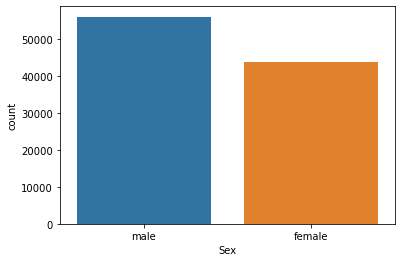

In [45]:
display(data['Sex'].value_counts())
sns.countplot(x="Sex", data=data);

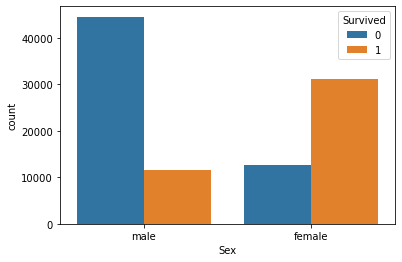

In [46]:
sns.countplot(data=data, x='Sex', hue='Survived');

**В полном наборе данных мужчин больше чем женщин: 56114 против 43886. Но выжило женщим больше чем мужчин как в процентном, так в и абсолютном значении**

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

**Посмотрим распределение пассажиров по возрастам**

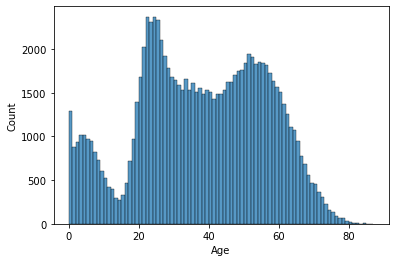

In [74]:
sns.histplot(x="Age", data=data, binwidth=1);

**Посмотрим график распределения по возрасту с разделение на выживших и невыживших**

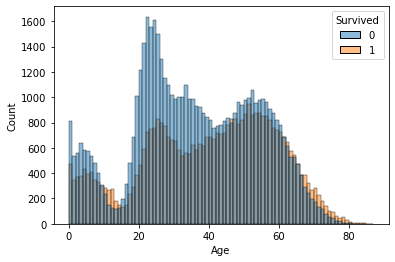

In [76]:
sns.histplot(x="Age", data=data, hue='Survived', binwidth=1);

In [79]:
data["Age"].describe()

count    96708.000000
mean        38.355472
std         18.313556
min          0.080000
25%         25.000000
50%         39.000000
75%         53.000000
max         87.000000
Name: Age, dtype: float64

In [100]:
data[data["Survived"] == 1]["Age"].describe()

count    41418.000000
mean        40.553799
std         18.742172
min          0.080000
25%         27.000000
50%         43.000000
75%         55.000000
max         87.000000
Name: Age, dtype: float64

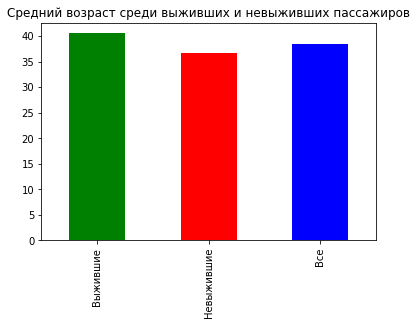

In [102]:
pd.Series([data[data["Survived"] == 1]["Age"].mean(), \
           data[data["Survived"] == 0]["Age"].mean(),\
           data["Age"].mean()],
         index = ["Выжившие", "Невыжившие", "Все"],).plot(kind="bar", color=["green", "red", "blue"]);
plt.title("Средний возраст среди выживших и невыживших пассажиров");

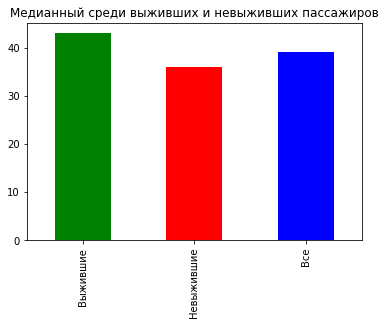

In [103]:
pd.Series([data[data["Survived"] == 1]["Age"].median(), \
           data[data["Survived"] == 0]["Age"].median(),\
           data["Age"].median()],
         index = ["Выжившие", "Невыжившие", "Все"],).plot(kind="bar", color=["green", "red", "blue"]);
plt.title("Медианный среди выживших и невыживших пассажиров");

**Показатели среднего и медианного возраста говорят о том, что среди выжившие в среднем были старше чем невыжившие. Это подтверждает также совмещенный график по возрасту. На нем видно небольшой сдвиг вправо по выжившим.**

**Поделим пассажиров по возрастным группам и построим график отношения выживших в данной возрастной группе к общему числу пассажиров в этой возрастной группе**

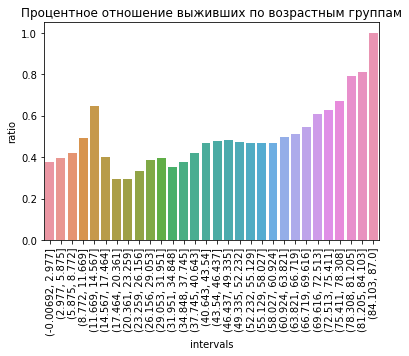

In [115]:
data['age_groups'] = pd.cut(data.Age, bins=30)
df_age = data["age_groups"].value_counts().reset_index()
df_age = df_age.rename(columns={'index': 'intervals', 'age_groups': 'counts'})
df_age_survived = data['age_groups'][data['Survived']==True].value_counts().reset_index()
df_age_survived = df_age_survived.rename(columns={'index': 'intervals', 'age_groups': 'survived_counts'})
df_s = df_age.merge(df_age_survived, on='intervals')
df_s['ratio'] = df_s.survived_counts/df_s.counts
sns.barplot(x='intervals', y='ratio', data=df_s)
ticks = plt.xticks(rotation=90)
plt.title("Процентное отношение выживших по возрастным группам");

**Этот график подтверждает рост процетов выживших с увеличением возраста**

**Наши исследования показывают, что чем больше возраст  тем выше были шансы выжить на Титанике также вырастали**

In [142]:
data = data.drop(columns="age_groups")

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

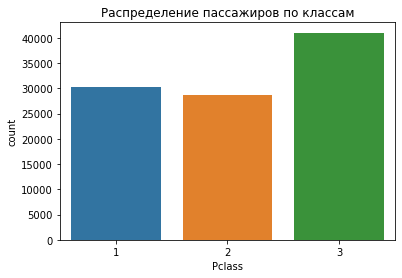

In [116]:
sns.countplot(x="Pclass", data=data);
plt.title("Распределение пассажиров по классам");

**Больше всего пассажиров в 3 классе**

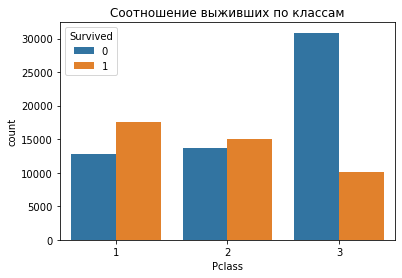

In [119]:
sns.countplot(data=data, x="Pclass", hue="Survived");
plt.title("Соотношение выживших по классам");

**Больше всего по классам пассажиров не выжило в 3 классе. Количество пассажиров не выживших в третьем классе превышаем суммарное количество не выживших в первом и втором классе. Также в 3 классе меньше всего выживших в процентном отношении. Самый безопасный класс, с наибольшей долей выживших это первый класс**

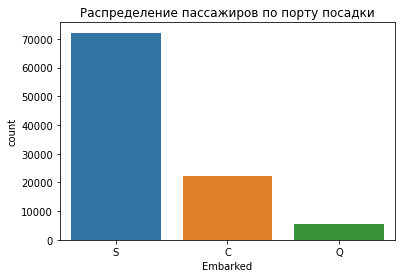

In [128]:
# ports = {"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"}
s = sns.countplot(x='Embarked', data=data);
plt.title("Распределение пассажиров по порту посадки");


**Больше всего пассажиров село на борт в порту Саутгемптона**

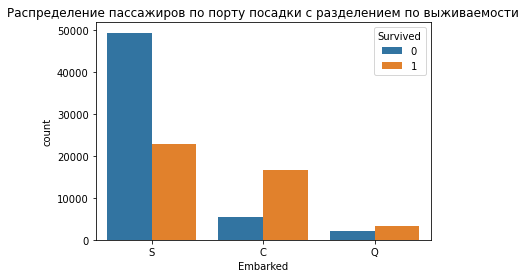

In [136]:
# ports = {"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"}
s = sns.countplot(x='Embarked', hue="Survived", data=data);
plt.title("Распределение пассажиров по порту посадки с разделением по выживаемости");

**Больше всего невыживших пассажиров так же село на борт в порту Саутгемптона. Лучшее соотношение по числу выживших у тех кто сел на борт в порту Шербурга. Предполагаю, что имело место половая диспропорция в зависимости от порта посадки**

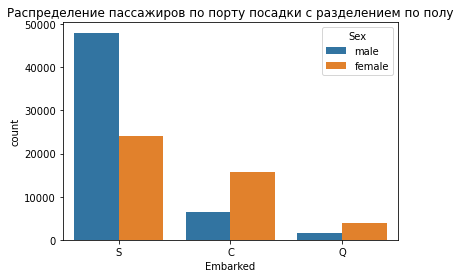

In [137]:
sns.countplot(x="Embarked", data=data, hue="Sex")
plt.title("Распределение пассажиров по порту посадки с разделением по полу");

**Предположение о половой диспропорции в зависимости от порта посадки подтвердилось. Интересно, что график с разделением по выжившим довольно точно повторяет график с разделением по полу**

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

**Посмотрим общую информацию по имеющимся данным**

In [143]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 11.2+ MB


**Для колонок Survived, PClass, Name, Sex, SibSp, Parch все значения не нулевые. Также присутствуют колонки с пропущенными значениями: Age, Ticket, Fare, Cabin, Embarked.**

**Найдем количество пропущенных значений в каждом столбце**

In [148]:
data.isna().sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age          3292
SibSp           0
Parch           0
Ticket       4623
Fare          134
Cabin       67866
Embarked      250
dtype: int64

**Посчитаем процент пропущенных ячеек**

In [165]:
data.isna().sum()/data.shape[0]

Survived    0.00000
Pclass      0.00000
Name        0.00000
Sex         0.00000
Age         0.03292
SibSp       0.00000
Parch       0.00000
Ticket      0.04623
Fare        0.00134
Cabin       0.67866
Embarked    0.00250
dtype: float64

**Больше всего процент пропущенных значений в колонке Cabin - 68%, меньше всего в колонке Embarked - 0.3%**

**Выведем данные о пропущенных ячейках графически**

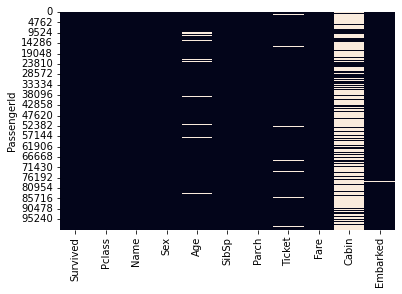

In [166]:
sns.heatmap(data.isnull(), cbar=False);

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

**Предполагаю что можно избавиться от колонки Cabin, поскольку в ней больше всего пропущенных данных и думаю, что она не несет достаточного количества значимой для предсказания информации.  К счастью, в столбце Выжившие у нас нет пропущенных данных.**

**Думаю данные в столбце Embarked можно заполнить портом в котором село наибольшее число пассажиров. Колонку Ticket я считаю можно исключить так же как малосодержательную. Колонки Age и Fare я предлагаю заполнить медианными значениями.**

In [181]:
data = data.drop(columns=["Ticket", "Cabin"])

In [182]:
data["Embarked"].fillna("S", inplace = True)

In [190]:
data["Age"].fillna(data["Age"].median(), inplace = True)

In [193]:
data["Fare"].fillna(data["Fare"].median(), inplace = True)

In [194]:
data.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [50]:
## your code

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [51]:
## your code

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.